### 1 - Objetivo


O objetivo deste trabalho é criar uma inteligência artificial capaz de distinguir entre uma rua asfaltada e uma estrada de chão.

### 2 - Esclarecimento

Este trabalho foi desenvolvido com base nas lições do curso <a href="https://course.fast.ai/" target="_blank">'Practical Deep Learning for Coders'</a> - Lição 1.

### 3 - Motivação

Dado que o modal de transporte mais amplamente utilizado no Brasil é o rodoviário (representando cerca de 60%, de acordo com a Confederação Nacional de Transportes), este trabalho tem como objetivo auxiliar na identificação do estado das estradas, a fim de facilitar o trabalho de órgãos públicos e empresas do setor no mapeamento da situação rodoviária brasileira.

Clique aqui para acessar a <a href="https://agenciadenoticias.ibge.gov.br/agencia-sala-de-imprensa/2013-agencia-de-noticias/releases/14707-asi-ibge-mapeia-a-infraestrutura-dos-transportes-no-brasil" target="_blank">referência</a>.

### 4 - Instalação

Para realizar a configuração do ambiente que rodará o projeto é necessário a instalação das seguintes tecnologias:

- Python3
- Visual Studio Code
- Pip

Para instalar todas as dependências usadas para rodar esse projeto estão listadas nesse arquivo <a href="https://drive.google.com/file/d/1I8yGRNiamuRmOLWHMZaPFVicnaV02cGW/view?usp=sharing" target="_blank">requirements.txt</a>.

- Para instalar as dependências listas no arquivo basta rodar o seguinte comando no terminal: pip install -r requirements.txt

Extensões para o Visual Studio Code

- Jupyter
- Jupyter Keymap
- Jupyter Cell Tags

### 5 - Criação do Projeto

Para iniciar o projeto, vamos criar uma função que retornará links de imagens encontradas ao pesquisar um termo específico no DuckDuckGo.

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *
from fastbook import *
from fastai.vision.all import *
    
def search_images(term, max_images=200):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Utilizando a função mencionada, em conjunto com a função "download_images", neste passo, baixaremos 200 imagens de cada uma das seguintes pesquisas: "rua asfaltada" e "estrada de chão". Essas imagens serão utilizadas para treinar o nosso modelo.

In [2]:
searches = 'rua asfaltada', 'estrada de chão'
path = Path('tipos_rua')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'rua asfaltada'


/home/valdersonjr/valderson/faculdade/aprendizado-maquina/env/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/home/valdersonjr/valderson/faculdade/aprendizado-maquina/env/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/home/valdersonjr/valderson/faculdade/aprendizado-maquina/env/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Searching for 'estrada de chão'


Seguindo o exemplo <a href="https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data" target="_blank">"Is it a bird? Creating a model from your own data"</a> demonstrado no curso, a próxima linha de código será responsável por remover imagens baixadas incorretamente e que não serão úteis para o treinamento do nosso modelo.

In [3]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

O código a seguir é um DataLoader, que é um objeto que contém as imagens a serem utilizadas para treinar o modelo. O DataLoader a seguir será criado utilizando DataBlock.

- blocks=(ImageBlock, CategoryBlock): as entradas (imagens ou "ImageBlock") serão subdivididas em categorias (ou "CategoryBlock").
- get_items=get_image_files: essa função retornará uma lista de todas as imagens encontradas em um determinado caminho ou diretório.
- splitter=RandomSplitter(valid_pct=0.2, seed=42): irá pegar 20% (valid_pct=0.2) dos dados para servirem como base para validar o modelo.
- get_y=parent_label: Isso irá rotular cada imagem com o nome do seu "pai". Por exemplo, se a imagem pertence à categoria "floresta", ela será rotulada como "floresta".
- item_tfms=[Resize(192, method='squish')]: redimensionará as imagens para que elas se ajustem a uma resolução de 192x192 pixels por meio do método de "esmagamento".

In [4]:
street_type = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

In [5]:
dls = street_type.dataloaders(path)

/home/valdersonjr/valderson/faculdade/aprendizado-maquina/env/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


É possível ver parte do lote de imagens tanto do conjunto de treinamento quanto do de validação, como mostrado nas duas células seguintes:

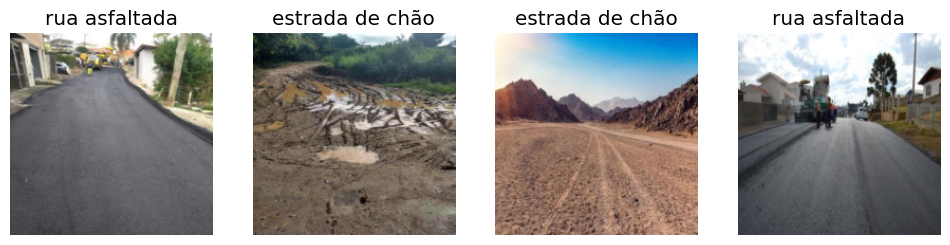

In [6]:
dls.train.show_batch(max_n=4, nrows=1)

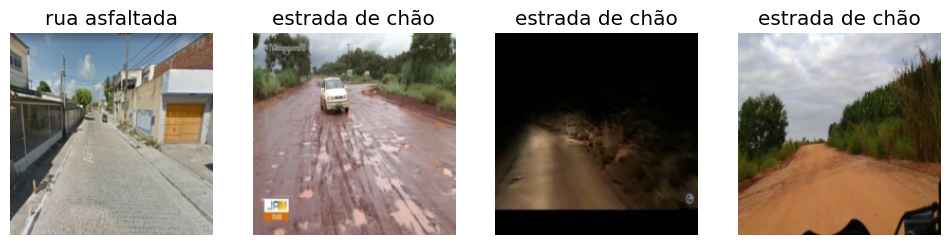

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)

Com tudo pronto, agora vamos treinar o modelo. Para isso, o fastai fornece o método "fine_tune", que automaticamente aplica as melhores práticas para o aprimoramento de um modelo pré-treinado.

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/valdersonjr/valderson/faculdade/aprendizado-maquina/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/valdersonjr/valderson/faculdade/aprendizado-maquina/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.272319,2.427427,0.545455,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.512307,0.674976,0.333333,00:01
1,0.375766,0.211866,0.060606,00:01
2,0.277999,0.140392,0.060606,00:01


O próximo passo será baixar uma imagem da internet para testar nosso modelo treinado para distinguir os tipos de estradas.

Searching for 'estrada de chão'


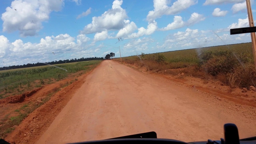

In [9]:
download_url(search_images('estrada de chão', max_images=1)[0], 'estrada_de_chao.jpg', show_progress=False)
Image.open('estrada_de_chao.jpg').to_thumb(256,256)

### 6 - Testando o Modelo

In [10]:
is_estrada_de_chao,_,probs = learn.predict(PILImage.create('estrada_de_chao.jpg'))
print(f"Isso é uma: {is_estrada_de_chao}.")
print(f"Probabilidade de ser uma estrada de chão: {probs[0]:.4f}")

Isso é uma: estrada de chão.
Probabilidade de ser uma estrada de chão: 0.9998


Obteve-se uma acurácia de 99% na identificação de uma estrada de chão.

### 7 - Problemas enfrentados:

Ao rodar a linha de código `learn.fine_tune(3)`, usada para treinar ainda mais o modelo, o jupyter server retornava a mensagem "The Kernel crashed while executing code in the the current cell".

Para resolver esse problema, busquei em fóruns, como <a href="https://forums.fast.ai/t/the-kernel-for-ch01-ipynb-appears-to-have-died-it-will-restart-automatically/103485/2" target="_blank">este</a>, e descobri que se tratava de um problema de compatibilidade com as versões do torch. As versões recomendadas (`torch==1.11.0` e `torchvision==0.12.0`) não solucionaram meu problema devido a alguma incompatibilidade com minha placa de vídeo, e retornaram a mensagem de erro: 'NVIDIA GeForce RTX 3050 with CUDA capability sm_86 is not compatible with the current PyTorch installation' ao criar o datablock."

O problema foi resolvido ao atualizar as versões, começando com as listadas anteriormente e testando até encontrar uma compatível. Todas as dependências utilizadas, incluindo suas versões, estão detalhadas na seção 4 deste artigo.